In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def log_normal_standard(z):
    return -0.5 * (math.log(2 * math.pi) + z.pow(2)).flatten(1).sum(dim=1)

def bits_per_dim_from_logpx(log_px, C, H, W):
    D = C * H * W
    log_px = log_px - D * math.log(256.0)

    nll = -log_px.mean()
    bpd = nll / (math.log(2.0) * D)
    return nll, bpd

def dequantize(x):
    x = x * 255.0
    x = x + torch.rand_like(x)
    x = x / 256.0
    return x

def logit_preprocess(x, alpha=1e-2):
    """Uniform dequantization + logit transform to R."""
    x = dequantize(x)
    x = x * (1 - 2 * alpha) + alpha
    x = x.clamp(alpha, 1 - alpha)

    # log |det J| from scaling + logit
    logdet = math.log(1 - 2 * alpha) * x[0].numel()
    logdet = x.new_full((x.size(0),), logdet)
    logdet = logdet + (-torch.log(x) - torch.log1p(-x)).flatten(1).sum(dim=1)

    y = torch.log(x) - torch.log1p(-x)
    return y, logdet

def logit_postprocess(y, alpha=1e-2):
    x = torch.sigmoid(y)
    x = (x - alpha) / (1 - 2 * alpha)
    return x.clamp(0.0, 1.0)


In [3]:
def squeeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C, H//2, 2, W//2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    return x.view(B, C*4, H//2, W//2)

def unsqueeze2x2(x):
    B, C, H, W = x.shape
    x = x.view(B, C//4, 2, 2, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    return x.view(B, C//4, H*2, W*2)

In [4]:
class ActNorm(nn.Module):
    def __init__(self, C, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.bias = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.log_scale = nn.Parameter(torch.zeros(1, C, 1, 1))
        self.initialized = False

    @torch.no_grad()
    def initialize(self, x):
        mean = x.mean(dim=[0,2,3], keepdim=True)
        std = x.std(dim=[0,2,3], keepdim=True)
        self.bias.data = -mean
        self.log_scale.data = torch.log(1.0/(std + self.eps))
        self.initialized = True

    def forward(self, x):
        if self.training and (not self.initialized):
            self.initialize(x)
        y = (x + self.bias) * torch.exp(self.log_scale)
        B, C, H, W = x.shape
        logdet = (H*W) * self.log_scale.view(1, C).sum(dim=1)
        return y, logdet.expand(B)

    def inverse(self, y):
        return y * torch.exp(-self.log_scale) - self.bias

In [5]:
class ChannelPermute(nn.Module):
    def __init__(self, C):
        super().__init__()
        perm = torch.randperm(C)
        inv = torch.empty_like(perm)
        inv[perm] = torch.arange(C)
        self.register_buffer("perm", perm)
        self.register_buffer("invperm", inv)

    def forward(self, x):
        # logdet = 0
        return x[:, self.perm, :, :], torch.zeros(x.size(0), device=x.device)

    def inverse(self, y):
        return y[:, self.invperm, :, :]

In [6]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, C):
        super().__init__()
        # orthogonal init
        w = torch.linalg.qr(torch.randn(C, C)).Q
        self.weight = nn.Parameter(w)

    def forward(self, x):
        B, C, H, W = x.shape
        Wmat = self.weight
        y = F.conv2d(x, Wmat.view(C, C, 1, 1))
        logdetW = torch.slogdet(Wmat)[1]
        logdet = (H*W) * logdetW
        return y, logdet.expand(B)

    def inverse(self, y):
        C = y.size(1)
        Winv = torch.inverse(self.weight)
        return F.conv2d(y, Winv.view(C, C, 1, 1))

In [7]:
class CouplingNN(nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, hidden_ch, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_ch, out_ch, 3, padding=1),
        )
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

class AffineCoupling(nn.Module):
    def __init__(self, C, hidden=64, clamp=2.0):
        super().__init__()
        assert C % 2 == 0
        self.nn = CouplingNN(C//2, hidden, C)  # outputs s,t for other half
        self.clamp = clamp

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        h = self.nn(x1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        y2 = x2 * torch.exp(s) + t
        y = torch.cat([x1, y2], dim=1)
        logdet = s.flatten(1).sum(dim=1)
        return y, logdet

    def inverse(self, y):
        y1, y2 = torch.chunk(y, 2, dim=1)
        h = self.nn(y1)
        s, t = torch.chunk(h, 2, dim=1)
        s = self.clamp * torch.tanh(s / self.clamp)

        x2 = (y2 - t) * torch.exp(-s)
        return torch.cat([y1, x2], dim=1)

In [8]:
class FlowStep(nn.Module):
    def __init__(self, C, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.actnorm = ActNorm(C)
        self.mixer = Invertible1x1Conv(C) if mixer == "conv1x1" else ChannelPermute(C)
        self.coupling = AffineCoupling(C, hidden=hidden)

    def forward(self, x):
        x, ld1 = self.actnorm(x)
        x, ld2 = self.mixer(x)
        x, ld3 = self.coupling(x)
        return x, (ld1 + ld2 + ld3)

    def inverse(self, z):
        z = self.coupling.inverse(z)
        z = self.mixer.inverse(z)
        z = self.actnorm.inverse(z)
        return z

In [9]:
class GlowMiniMultiScale(nn.Module):
    """
    2-level multi-scale:
      Level1: squeeze -> K steps -> split (half to z1)
      Level2: squeeze -> K steps -> rest to z2
    """
    def __init__(self, K=4, hidden=64, mixer="conv1x1"):
        super().__init__()
        self.K = K
        self.hidden = hidden
        self.mixer = mixer

        self.level1 = nn.ModuleList([FlowStep(4, hidden, mixer=mixer) for _ in range(K)])
        self.level2 = nn.ModuleList([FlowStep(8, hidden, mixer=mixer) for _ in range(K)])

    def forward(self, x):
        logdet_total = torch.zeros(x.size(0), device=x.device)

        h = squeeze2x2(x)
        for step in self.level1:
            h, ld = step(h)
            logdet_total += ld

        z1, h = torch.chunk(h, 2, dim=1)

        h = squeeze2x2(h)
        for step in self.level2:
            h, ld = step(h)
            logdet_total += ld

        z2 = h

        log_pz = log_normal_standard(z1) + log_normal_standard(z2)
        log_px = log_pz + logdet_total

        return (z1, z2), log_px

    def inverse(self, z1, z2):
        # invert Level 2
        h = z2
        for step in reversed(self.level2):
            h = step.inverse(h)
        h = unsqueeze2x2(h)  # (B,2,14,14)

        # concat with z1 to reconstruct Level1 output
        h = torch.cat([z1, h], dim=1)  # (B,4,14,14)

        # invert Level 1
        for step in reversed(self.level1):
            h = step.inverse(h)
        x = unsqueeze2x2(h)  # (B,1,28,28)
        return x

    @torch.no_grad()
    def sample(self, n, device, temperature=0.7, postprocess_fn=None):
        z1 = temperature * torch.randn(n, 2, 14, 14, device=device)
        z2 = temperature * torch.randn(n, 8, 7, 7, device=device)
        x = self.inverse(z1, z2)
        if postprocess_fn is not None:
            x = postprocess_fn(x)
        return x

    @torch.no_grad()
    def encode(self, x):
        (z1, z2), _ = self.forward(x)
        return z1, z2

    @torch.no_grad()
    def decode(self, z1, z2, postprocess_fn=None):
        x = self.inverse(z1, z2)
        if postprocess_fn is not None:
            x = postprocess_fn(x)
        return x


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from contextlib import contextmanager


class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {
            name: p.detach().clone()
            for name, p in model.named_parameters()
            if p.requires_grad
        }
        self.backup = {}

    @torch.no_grad()
    def update(self, model):
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.shadow[name].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    def apply(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.backup[name] = p.detach().clone()
            p.data.copy_(self.shadow[name])

    def restore(self, model):
        if not self.backup:
            return
        for name, p in model.named_parameters():
            if p.requires_grad and name in self.backup:
                p.data.copy_(self.backup[name])
        self.backup = {}


def make_loaders(batch_size, seed=0):
    transform = transforms.ToTensor()
    ds = datasets.MNIST("./data", train=True, download=True, transform=transform)

    n_train = int(0.92 * len(ds))  # ~55k/5k split
    n_val = len(ds) - n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

    common = dict(batch_size=batch_size, num_workers=2, pin_memory=torch.cuda.is_available())
    train_loader = DataLoader(train_ds, shuffle=True, **common)
    val_loader = DataLoader(val_ds, shuffle=False, **common)
    return train_loader, val_loader


@torch.no_grad()
def evaluate_bpd(model, loader, device, alpha=1e-2):
    model.eval()
    total_bpd = 0.0
    total = 0
    for x, _ in loader:
        x = x.to(device)
        x_proc, logdet = logit_preprocess(x, alpha=alpha)
        (_, _), log_px = model(x_proc)
        log_px = log_px + logdet
        _, bpd = bits_per_dim_from_logpx(log_px, C=1, H=28, W=28)
        total_bpd += bpd.item() * x.size(0)
        total += x.size(0)
    return total_bpd / total


@contextmanager
def ema_scope(model, ema):
    if ema is None:
        yield
        return
    ema.apply(model)
    try:
        yield
    finally:
        ema.restore(model)


def train_one(
    model,
    loader,
    device,
    epochs=10,
    lr=1e-3,
    alpha=1e-2,
    warmup_steps=500,
    weight_decay=1e-5,
    max_grad_norm=5.0,
    ema_decay=0.999,
    val_loader=None,
):
    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), weight_decay=weight_decay)
    ema = EMA(model, decay=ema_decay) if ema_decay else None
    global_step = 0

    for ep in range(epochs):
        model.train()
        bpd_running = 0.0
        total = 0

        for x, _ in loader:
            x = x.to(device)
            x, logdet = logit_preprocess(x, alpha=alpha)

            (_, _), log_px = model(x)
            log_px = log_px + logdet

            nll, bpd = bits_per_dim_from_logpx(log_px, C=1, H=28, W=28)

            opt.zero_grad(set_to_none=True)
            nll.backward()
            if max_grad_norm:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()
            if ema:
                ema.update(model)

            global_step += 1
            if warmup_steps:
                warmup_scale = min(1.0, global_step / warmup_steps)
                for g in opt.param_groups:
                    g["lr"] = lr * warmup_scale

            bpd_running += bpd.item() * x.size(0)
            total += x.size(0)

        bpd_epoch = bpd_running / total
        msg = f"Epoch {ep+1:02d} | bits/dim: {bpd_epoch:.4f} | lr: {opt.param_groups[0]['lr']:.1e}"

        if val_loader is not None:
            with ema_scope(model, ema):
                val_bpd = evaluate_bpd(model, val_loader, device, alpha=alpha)
            msg += f" | val bpd: {val_bpd:.4f}"

        print(msg)

    return ema


In [11]:
torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

cfg = dict(
    epochs=35,
    batch_size=256,
    K=16,
    hidden=256,
    lr=1e-3,
    warmup_steps=1000,
    weight_decay=1e-5,
    max_grad_norm=5.0,
    alpha=1e-2,
    ema_decay=0.999,
    temperature=0.7,
)

train_loader, val_loader = make_loaders(cfg["batch_size"])

print("Training CONV1x1 model (logit preprocess + EMA)")
model_conv = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="conv1x1").to(device)
model_perm = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="permute").to(device)


Training CONV1x1 model (logit preprocess + EMA)


In [12]:
# ema_conv = train_one(
#     model_conv,
#     train_loader,
#     device,
#     epochs=cfg["epochs"],
#     lr=cfg["lr"],
#     alpha=cfg["alpha"],
#     warmup_steps=cfg["warmup_steps"],
#     weight_decay=cfg["weight_decay"],
#     max_grad_norm=cfg["max_grad_norm"],
#     ema_decay=cfg["ema_decay"],
#     val_loader=val_loader,
# )

# print("Sampling sanity-check")
# with ema_scope(model_conv, ema_conv):
#     samples = model_conv.sample(
#         16,
#         device,
#         temperature=cfg["temperature"],
#         postprocess_fn=lambda y: logit_postprocess(y, alpha=cfg["alpha"]),
#     )
# print(samples.shape, samples.min().item(), samples.max().item())

In [13]:
!git clone https://github.com/Nocimaa/GenAI

fatal: destination path 'GenAI' already exists and is not an empty directory.


In [14]:
import torch
ckpt_conv_path = "GenAI/glow_conv1x1_ckpt.pt"
ckpt_permute_path = "GenAI/glow_permute_ckpt.pt"


In [15]:
checkpoint_conv = torch.load(ckpt_conv_path, map_location="cuda", weights_only=False)
checkpoint_permute = torch.load(ckpt_permute_path, map_location="cuda", weights_only=False)

In [16]:
model_conv = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="conv1x1").to(device)
model_perm = GlowMiniMultiScale(K=cfg["K"], hidden=cfg["hidden"], mixer="permute").to(device)

model_conv.load_state_dict(checkpoint_conv["model"], strict=True)
model_conv.load_state_dict(checkpoint_conv["ema"].shadow, strict=False)
model_perm.load_state_dict(checkpoint_permute["model"], strict=True)
model_perm.load_state_dict(checkpoint_permute["ema"].shadow, strict=False)

# ema_conv = checkpoint_conv["ema"]
# ema_perm = checkpoint_permute["ema"]

cfg_conv = checkpoint_conv["cfg"]
cfg_perm = checkpoint_permute["cfg"]

model_conv.eval()
model_perm.eval()

print()

In [17]:
import torch
import matplotlib.pyplot as plt
import math

def _show_grid(x, title="", ncols=5):
    """
    x: Tensor [B,1,H,W] sur CPU ou GPU
    """
    x = x.detach().cpu()
    B = x.size(0)
    nrows = math.ceil(B / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2))
    if nrows == 1:
        axes = [axes]
    fig.suptitle(title)

    idx = 0
    for i in range(nrows):
        row_axes = axes[i] if isinstance(axes[i], (list, tuple)) else (axes[i] if hasattr(axes[i], "__len__") else [axes[i]])
        if hasattr(axes, "shape") and len(axes.shape) == 2:
            row_axes = axes[i]

        for j in range(ncols):
            ax = row_axes[j] if hasattr(row_axes, "__len__") else row_axes
            ax.axis("off")
            if idx < B:
                ax.imshow(x[idx, 0], cmap="gray")
            idx += 1

    plt.tight_layout()
    plt.show()

@torch.no_grad()
def generate_and_show(model, n_samples, device, title="Generated samples", alpha=1e-2, temperature=0.8, ema=None, ncols=5):
    model.eval()
    with ema_scope(model, ema):
        x = model.sample(
            n_samples,
            device,
            temperature=temperature,
            postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha),
        )
    _show_grid(x, title=title, ncols=ncols)

@torch.no_grad()
def reconstruct_and_show(model, loader, device, n=8, alpha=1e-2, ema=None):

    model.eval()

    x, _ = next(iter(loader))
    x = x[:n].to(device)
    x_proc, _ = logit_preprocess(x, alpha=alpha)

    with ema_scope(model, ema):
        z1, z2 = model.encode(x_proc)
        x_rec = model.decode(
            z1, z2,
            postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha),
        )

    _show_grid(x, title="Original MNIST", ncols=min(n, 8))
    _show_grid(x_rec, title="Reconstructions (Glow)", ncols=min(n, 8))

@torch.no_grad()
def interpolate_and_show(model, loader, device, idx_a=0, idx_b=1, steps=12, alpha=1e-2, ema=None, title="Latent interpolation"):
    model.eval()

    x, _ = next(iter(loader))
    x = x.to(device)

    xa = x[idx_a:idx_a+1]
    xb = x[idx_b:idx_b+1]
    xa_proc, _ = logit_preprocess(xa, alpha=alpha)
    xb_proc, _ = logit_preprocess(xb, alpha=alpha)

    with ema_scope(model, ema):
        z1a, z2a = model.encode(xa_proc)
        z1b, z2b = model.encode(xb_proc)

        imgs = []
        for t in torch.linspace(0, 1, steps, device=device):
            z1 = (1 - t) * z1a + t * z1b
            z2 = (1 - t) * z2a + t * z2b
            xi = model.decode(z1, z2, postprocess_fn=lambda y: logit_postprocess(y, alpha=alpha))
            imgs.append(xi[0:1])

    seq = torch.cat(imgs, dim=0)

    _show_grid(torch.cat([xa, xb], dim=0), title="Endpoints (real)", ncols=2)
    _show_grid(seq, title=title, ncols=min(steps, 12))


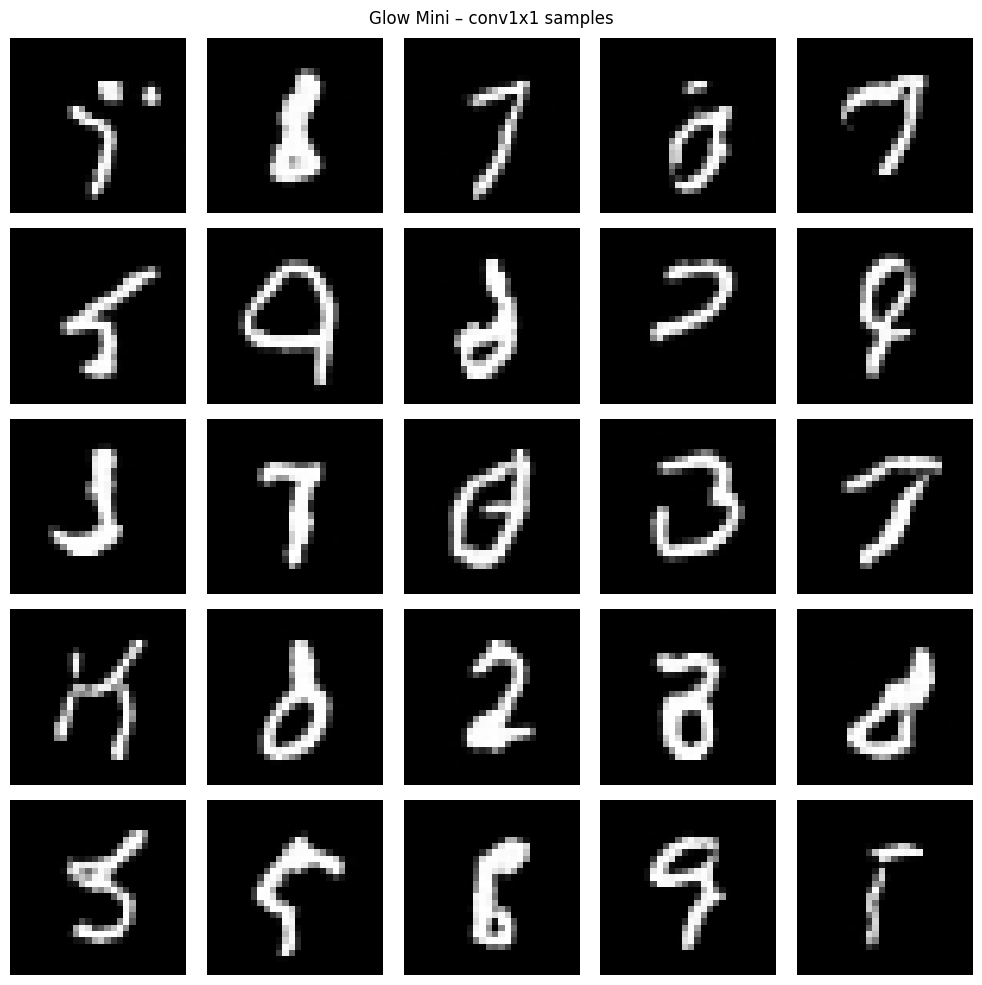

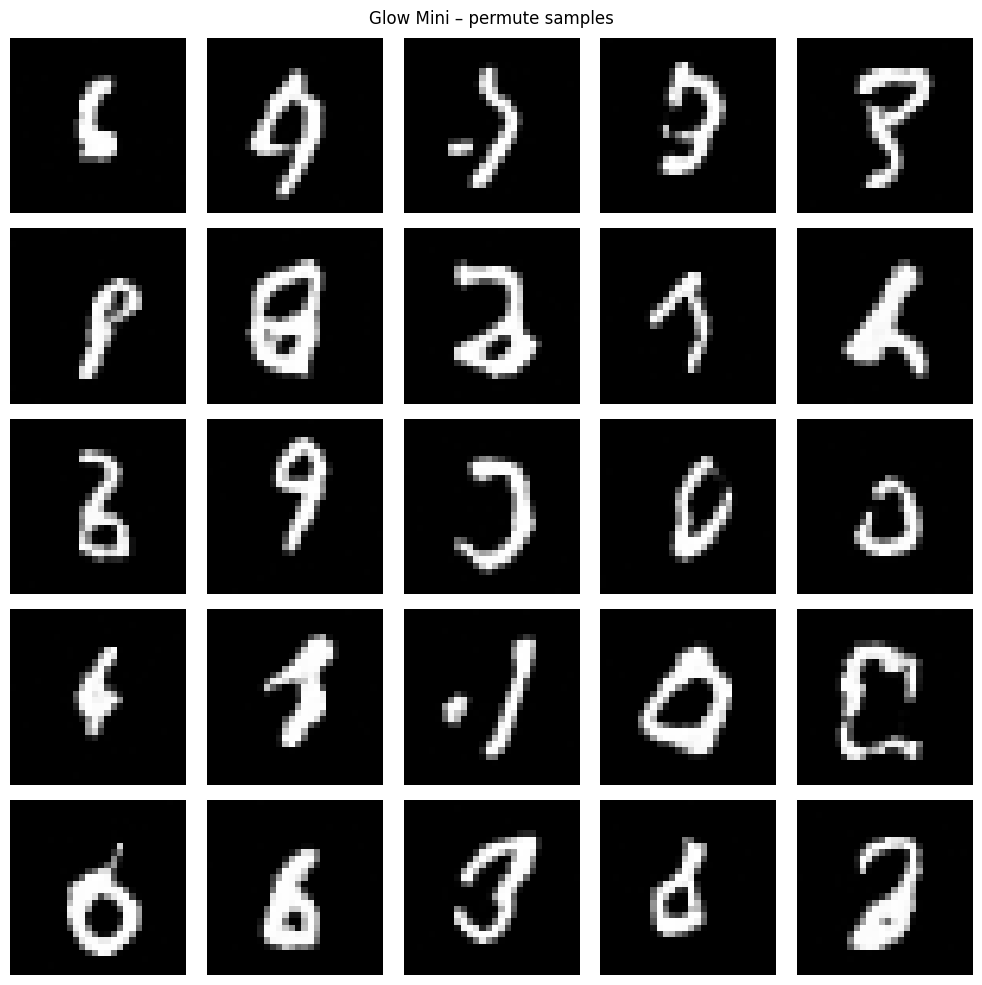

In [18]:
generate_and_show(model_conv, n_samples=25, device=device,
                  alpha=cfg_conv["alpha"], temperature=cfg_conv["temperature"], title="Glow Mini – conv1x1 samples", ncols=5)

generate_and_show(model_perm, n_samples=25, device=device,
                  alpha=cfg_perm["alpha"], temperature=cfg_perm["temperature"], title="Glow Mini – permute samples", ncols=5)

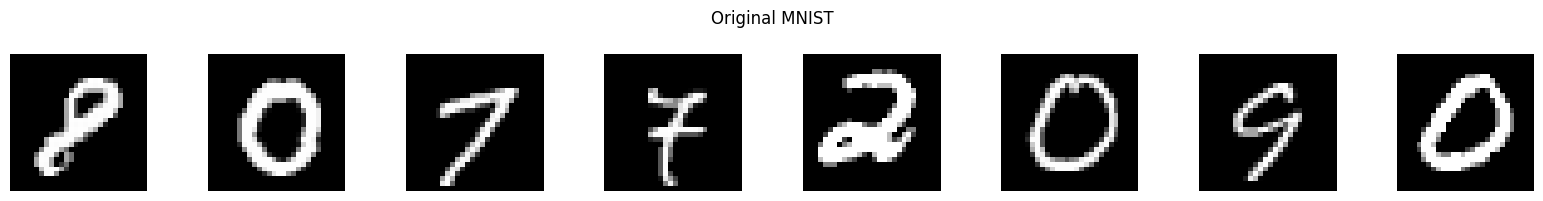

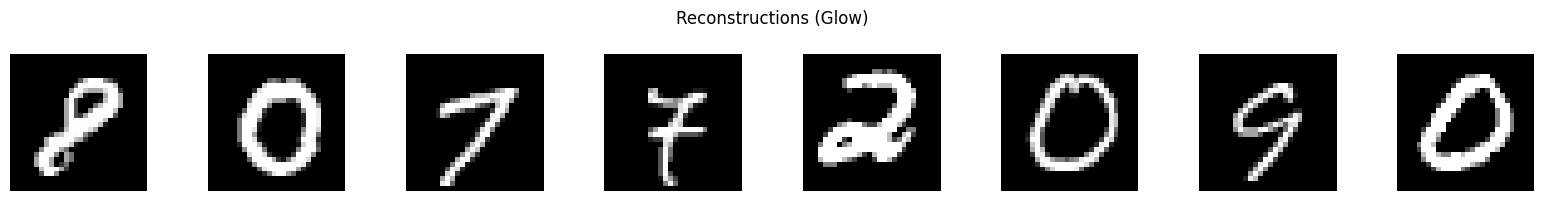

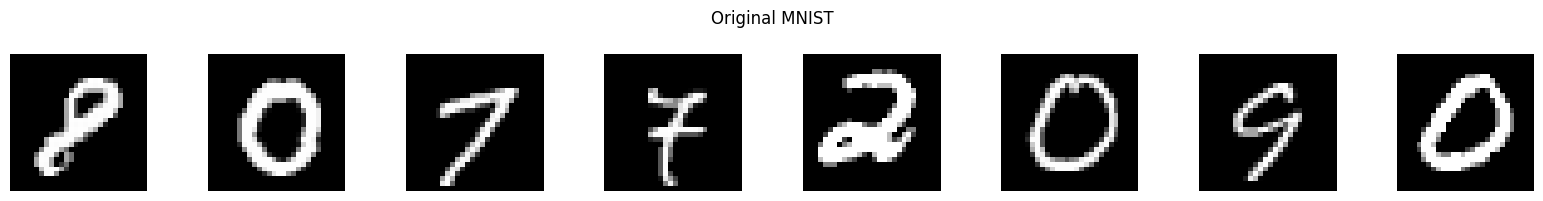

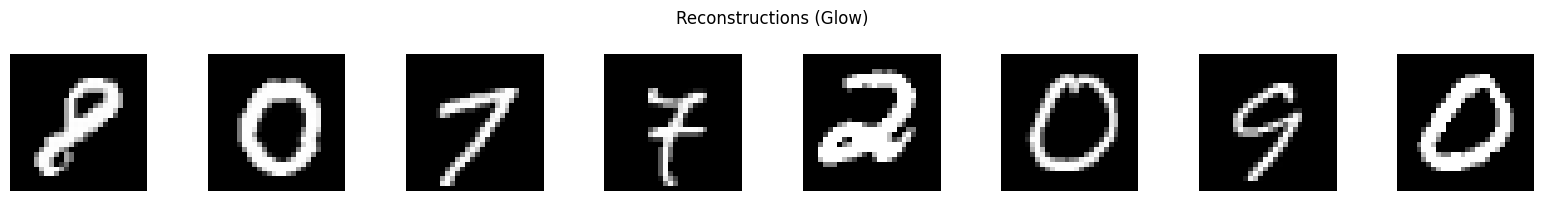

In [19]:
reconstruct_and_show(model_conv, val_loader, device, n=8, alpha=cfg_conv["alpha"])
reconstruct_and_show(model_perm, val_loader, device, n=8, alpha=cfg_perm["alpha"])


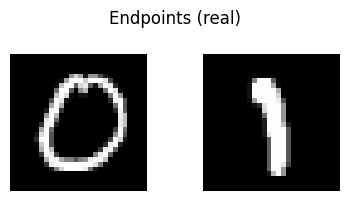

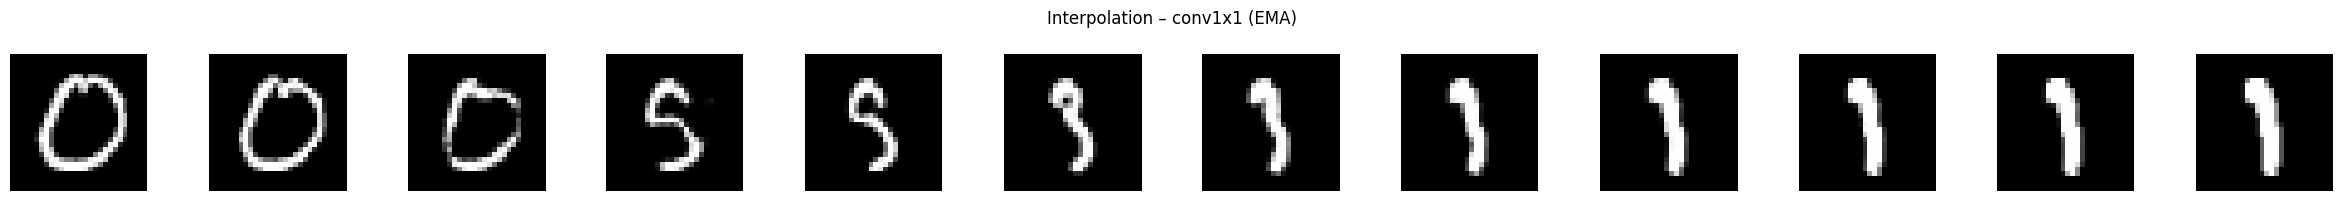

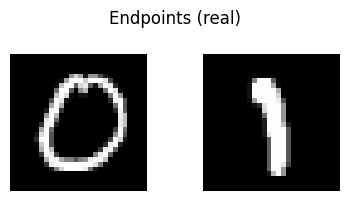

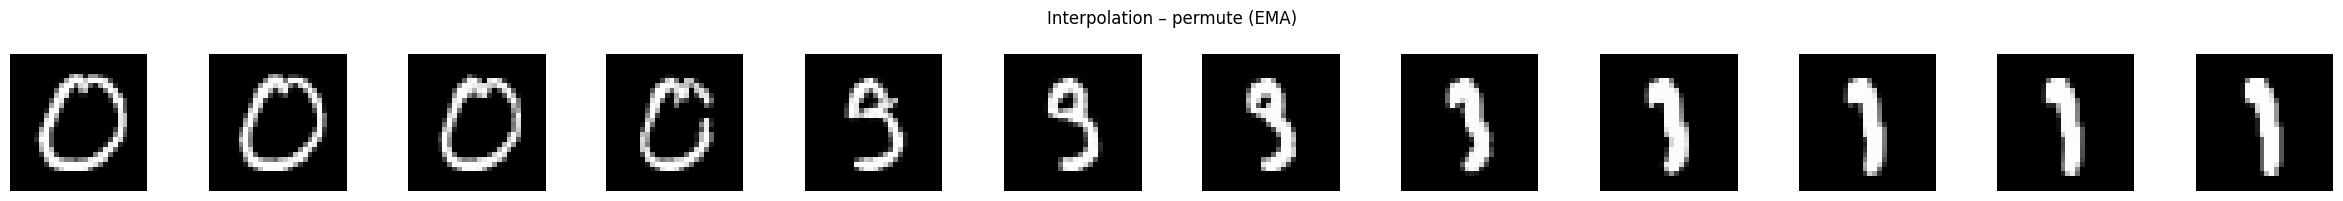

In [20]:
interpolate_and_show(model_conv, val_loader, device, idx_a=5, idx_b=12, steps=12,
                     alpha=cfg_conv["alpha"], title="Interpolation – conv1x1 (EMA)")

interpolate_and_show(model_perm, val_loader, device, idx_a=5, idx_b=12, steps=12,
                     alpha=cfg_perm["alpha"], title="Interpolation – permute (EMA)")
